1) Deep Learning - Use this dataset to detect age: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset. Build two deep models - one from scratch and the other using a pretrained model to obtain embeddings of the given data. Compare the performances.

2) NLP - Scrape about 5000 reviews on any product of your choice on Amazon along with their ratings (1-5). Considering reviews with 1-2 as 'negative' and 4-5 as 'positive', develop an NBC classifier.

Prepare a bunch of slides on the approaches and results. Your team will have about 15-20 minutes to present.



This notebook would be specific to using a pretrained model to classify the face images to detect the age. Starting section is the setup in google colab.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
from keras import Sequential

from matplotlib import pyplot as plt
from keras.utils import to_categorical

from sklearn import metrics
import cv2

import PIL.Image as Image

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
os.getcwd()

'/content'

In [ ]:
cd

/root


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download arashnic/faces-age-detection-dataset

 90% 43.0M/47.8M [00:02<00:00, 13.1MB/s]
100% 47.8M/47.8M [00:02<00:00, 18.9MB/s]


In [ ]:
! unzip faces-age-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/4047.jpg          
  inflating: Train/4049.jpg          
  inflating: Train/405.jpg           
  inflating: Train/4051.jpg          
  inflating: Train/4052.jpg          
  inflating: Train/4053.jpg          
  inflating: Train/4055.jpg          
  inflating: Train/4056.jpg          
  inflating: Train/4057.jpg          
  inflating: Train/4058.jpg          
  inflating: Train/4059.jpg          
  inflating: Train/406.jpg           
  inflating: Train/4060.jpg          
  inflating: Train/4061.jpg          
  inflating: Train/4062.jpg          
  inflating: Train/4065.jpg          
  inflating: Train/4066.jpg          
  inflating: Train/4068.jpg          
  inflating: Train/4069.jpg          
  inflating: Train/407.jpg           
  inflating: Train/4070.jpg          
  inflating: Train/4072.jpg          
  inflating: Train/4073.jpg          
  inflating: Train/4076.jpg          
  inflating: Train/4078.jpg          

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.9.2'

In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Importing the data

In [ ]:
data = pd.read_csv("/root/train.csv")
data.head(3)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE


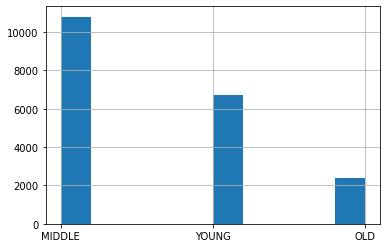

In [ ]:
data['Class'].hist() #we can observe some class imbalance in the dataset

In [ ]:
data['Class'].replace(['YOUNG', 'MIDDLE','OLD'],
                        [0, 1, 2], inplace=True)
data.head(3)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1


Below functions help in reading pictures from the folder

In [ ]:
def imageReader(path,ch = 3, resize=(100,100)):
	kp = tf.io.read_file(path)
	kp = tf.image.decode_jpeg(kp, channels=ch)
	kp = tf.image.convert_image_dtype(kp, dtype=tf.float32)
	kp = tf.image.resize(kp, resize)
	return kp

def load_data(image_path, label):
    image = imageReader(image_path, 3, (100,100))
    
    return (image, label)

In [ ]:
data['Class'].value_counts()

1    10804
0     6706
2     2396
Name: Class, dtype: int64

In [ ]:
image_paths = glob.glob('/root/Train/*.jpg')
image_paths = image_paths
print(len(image_paths))

19906


In [ ]:
label_list = []
for i in image_paths:
    _,tail = os.path.split(i)
    label = data.loc[data['ID'] == tail]['Class'].values[0]
    label_list.append(label)

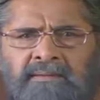

In [ ]:
image_shape=(100,100)
image1=Image.open(image_paths[1]).resize(image_shape)
image1

Resizing the images and adding them in X and y 

In [ ]:
X, y = [], []

for image in image_paths:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img,(100,100))
    X.append(resized_img)
    _,tail = os.path.split(image)
    label = data.loc[data['ID'] == tail]['Class'].values[0]
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# X[0]

In [ ]:
# np.unique(y_train)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,stratify=y,test_size=0.25)

In [ ]:
y_train.shape

(14929,)

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

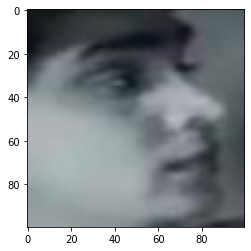

In [ ]:
plt.imshow(X[0]) #example - one of the train images

In [ ]:
X_train[0].shape

(100, 100, 3)

In [ ]:
#Import keras functions

from keras import Sequential
from keras.applications import VGG19,ResNet50
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

Importing Resnet50 model from Keras

In [ ]:
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(100,100,3))

In [ ]:
base_model_2.trainable=False

In [ ]:
model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
# model_2.add(Dense(4000,activation=('relu'),input_dim=512))
# model_2.add(Dense(2000,activation=('relu'))) 
# model_2.add(Dropout(.4))
# model_2.add(Dense(1000,activation=('relu'))) 
# model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
# model_2.add(Dense(500,activation=('relu')))
# model_2.add(Dropout(.2))
model_2.add(Dense(3,activation=('softmax'))) #This is the classification layer

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 3)                 98307     
                                                                 
Total params: 23,686,019
Trainable params: 98,307
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
batch_size= 100
epochs=50
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_2.fit(X_train_scaled,y_train,
                     epochs=5,verbose=1)

Epoch 1/5
467/467 [==============================] - 25s 32ms/step - loss: 1.1113 - accuracy: 0.5146
Epoch 2/5
467/467 [==============================] - 15s 31ms/step - loss: 1.0291 - accuracy: 0.5504
Epoch 3/5
467/467 [==============================] - 15s 32ms/step - loss: 1.0289 - accuracy: 0.5573
Epoch 4/5
467/467 [==============================] - 15s 32ms/step - loss: 0.9599 - accuracy: 0.5716
Epoch 5/5
467/467 [==============================] - 15s 32ms/step - loss: 1.0307 - accuracy: 0.5666


In [ ]:
y_pred_resnet=model_2.predict(X_test)
y_true=np.argmax(y_test,axis=1)

y_pred_classes = [np.argmax(element) for element in y_pred_resnet]


156/156 [==============================] - 5s 28ms/step


In [ ]:
model_2.evaluate(X_test,y_test)[1]

156/156 [==============================] - 6s 31ms/step - loss: 14.5060 - accuracy: 0.5347


0.5346594452857971

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.33      0.04      0.07      1677
           1       0.54      0.96      0.69      2701
           2       0.00      0.00      0.00       599

    accuracy                           0.53      4977
   macro avg       0.29      0.33      0.26      4977
weighted avg       0.41      0.53      0.40      4977



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting the confusion matrix

In [ ]:
confusion_mtx=confusion_matrix(y_true,y_pred_classes)

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
class_names=['YOUNG', 'MIDDLE','OLD']

Confusion matrix, without normalization


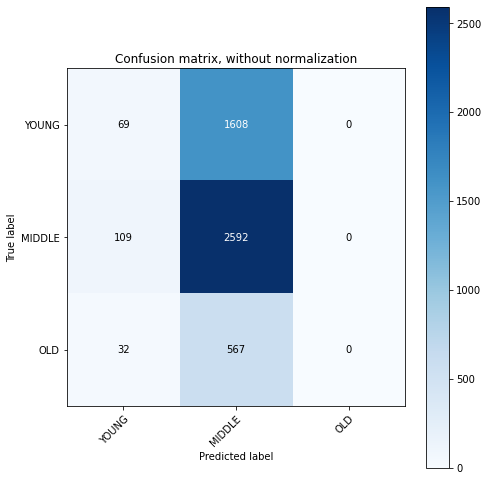

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


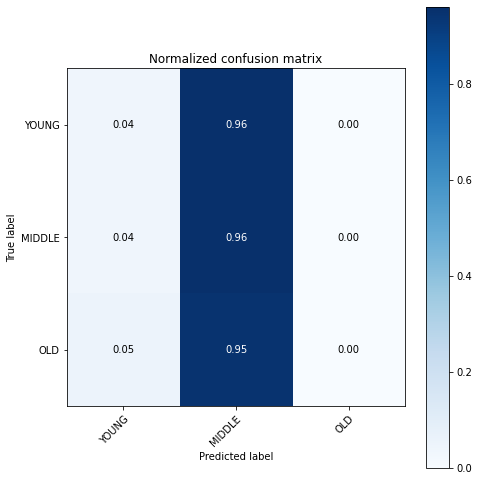

In [ ]:
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])

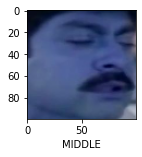

In [ ]:
plot_sample(X_test, y_true,4) #test file

In [ ]:
class_names[y_pred_classes[3]] #prediction

'MIDDLE'